In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import umap
from sklearn.preprocessing import StandardScaler

/Users/meg/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/meg/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/meg/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/

# 1. TF-IDF

In [2]:
tfidf = pd.read_csv('/Users/meg/Thesis/tfidf_embeddings.csv') # use for visualization
tfidf=tfidf.drop(['Unnamed: 0'], axis=1)
tfidf_umap = pd.read_csv('/Users/meg/Thesis/tfidf_umap_embeddings.csv') # use for clustering
tfidf_umap=tfidf_umap.drop(['Unnamed: 0'], axis=1)

movie_df = pd.read_csv('/Users/meg/Thesis/movie_df_final.csv')
movie_df = movie_df.drop(['Unnamed: 0', 'index'], axis=1)
movie_df=movie_df.reset_index()
movie_df_genre=movie_df[movie_df['Genre_Simple']!='unknown']

tfidf_genre=tfidf.reset_index()
tfidf_genre=tfidf_genre[tfidf_genre['index'].isin(movie_df_genre['index'])]
tfidf_genre=tfidf_genre.drop(['index'],axis=1)
print(tfidf_genre.shape)

tfidf_umap_genre=tfidf_umap.reset_index()
tfidf_umap_genre=tfidf_umap_genre[tfidf_umap_genre['index'].isin(movie_df_genre['index'])]
tfidf_umap_genre=tfidf_umap_genre.drop(['index'],axis=1)
print(tfidf_umap_genre.shape)

(27667, 15297)
(27667, 200)


In [3]:
W = pairwise_distances(tfidf_umap_genre, metric="euclidean") 
W.shape

(27667, 27667)

In [4]:
%%time
delta = 0.7
affinity = np.exp(- W ** 2 / (2. * delta ** 2))
sc = SpectralClustering(n_clusters=19, affinity='precomputed', random_state=0)
sc_clustering = sc.fit(affinity)

CPU times: user 1h 6min 48s, sys: 2min 13s, total: 1h 9min 2s
Wall time: 1h 11min 33s


In [5]:
normalized_mutual_info_score(sc_clustering.labels_, movie_df_genre['Genre_Simple'])

0.08685278112167356

In [6]:
%%time
reducer = umap.UMAP(random_state=42, n_components=2)
tfidf_umap_raw = reducer.fit_transform(tfidf_genre)
tfidf_umap_raw.shape
tfidf_umap_raw=pd.DataFrame(tfidf_umap_raw)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 6min 59s, sys: 12.4 s, total: 7min 12s
Wall time: 1min 49s


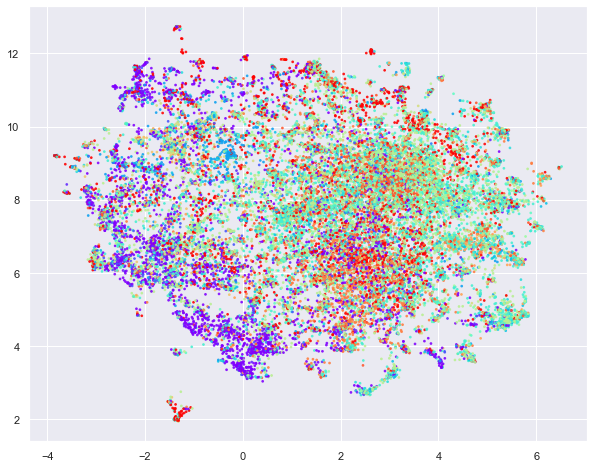

In [7]:
plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=tfidf_umap_raw[0],
            y=tfidf_umap_raw[1],
            c=movie_df_genre.Genre_Simple.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('TFIDF_Genre_PLT.png')

CPU times: user 666 ms, sys: 41 ms, total: 707 ms
Wall time: 682 ms


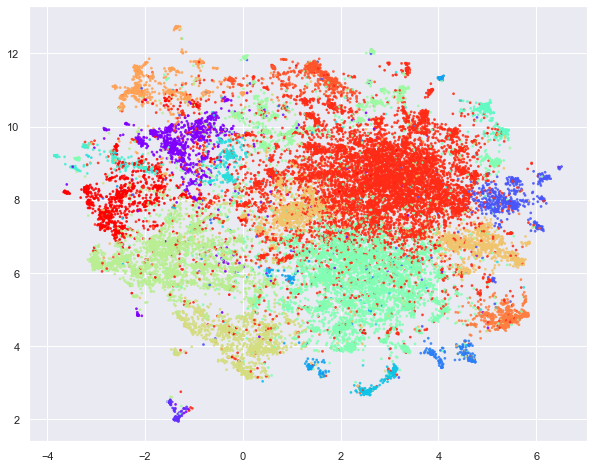

In [8]:
%%time 

sc_df=pd.DataFrame(sc_clustering.labels_)
sc_df = sc_df.rename(columns = {0:'cluster'})


plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=tfidf_umap_raw[0],
            y=tfidf_umap_raw[1],
            c=sc_df.cluster.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('TFIDF_Cluster_PLT.png')

In [9]:
tfidf_labels=sc_clustering.labels_

In [10]:
pd.DataFrame(sc_df.cluster).value_counts(['cluster'])

cluster
17         8584
9          5117
11         2775
13         1986
12         1404
18         1156
0          1111
10          872
14          820
2           766
16          676
15          537
8           387
6           361
7           273
5           247
3           239
4           218
1           138
dtype: int64

In [11]:
pd.DataFrame(sc_df.cluster).value_counts(['cluster'], normalize=True)

cluster
17         0.310261
9          0.184950
11         0.100300
13         0.071782
12         0.050746
18         0.041783
0          0.040156
10         0.031518
14         0.029638
2          0.027686
16         0.024433
15         0.019409
8          0.013988
6          0.013048
7          0.009867
5          0.008928
3          0.008638
4          0.007879
1          0.004988
dtype: float64

# 2. Doc2Vec

In [12]:
decvec = pd.read_csv('/Users/meg/Thesis/doc_2_vec_embeddings.csv')
decvec = decvec.drop(['Unnamed: 0'], axis=1)

movie_df = pd.read_csv('/Users/meg/Thesis/movie_df_final.csv')
movie_df = movie_df.drop(['Unnamed: 0', 'index'], axis=1)
movie_df=movie_df.reset_index()
movie_df_genre=movie_df[movie_df['Genre_Simple']!='unknown']

decvec_genre=decvec.reset_index()
decvec_genre=decvec_genre[decvec_genre['index'].isin(movie_df_genre['index'])]
decvec_genre=decvec_genre.drop(['index'],axis=1)
decvec_genre.shape

(27667, 200)

In [13]:
W = pairwise_distances(decvec_genre, metric="euclidean") 
W.shape

(27667, 27667)

In [14]:
%%time
delta = 0.7
affinity = np.exp(- W ** 2 / (2. * delta ** 2))
sc = SpectralClustering(n_clusters=19, affinity='precomputed', random_state=0)
sc_clustering = sc.fit(affinity)

CPU times: user 1h 12min, sys: 2min 34s, total: 1h 14min 34s
Wall time: 1h 17min 38s


In [15]:
normalized_mutual_info_score(sc_clustering.labels_, movie_df_genre['Genre_Simple'])

0.12334501621510062

In [16]:
%%time

reducer = umap.UMAP(random_state=2, n_components=2, min_dist=0)

scaled_document_embeddings2 = StandardScaler().fit_transform(decvec_genre)
scaled_document_embeddings2.shape

umapembeddings2 = reducer.fit_transform(scaled_document_embeddings2)
print(umapembeddings2.shape)
umapembeddings2=pd.DataFrame(umapembeddings2)

(27667, 2)
CPU times: user 31.9 s, sys: 2.04 s, total: 33.9 s
Wall time: 24.6 s


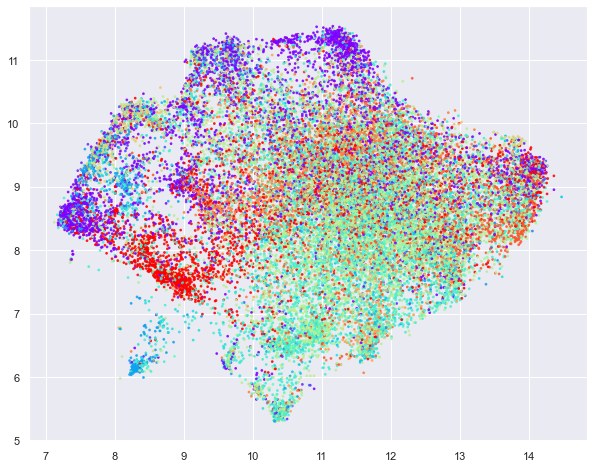

In [17]:
plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=movie_df_genre.Genre_Simple.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('Doc2Vec_genre_PLT.png')

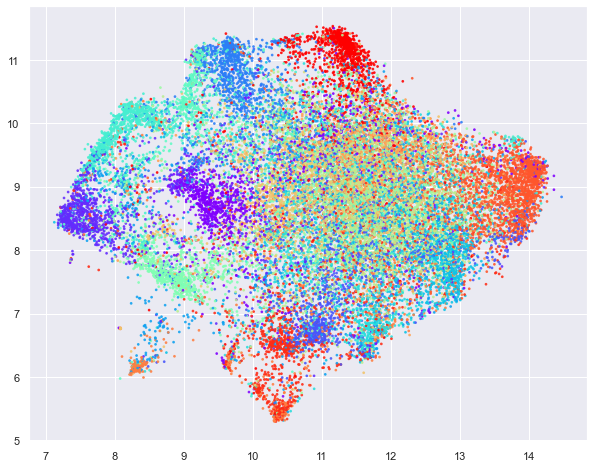

In [18]:
sc_df=pd.DataFrame(sc_clustering.labels_)
sc_df = sc_df.rename(columns = {0:'cluster'})


plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=sc_df.cluster.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('Doc2Vec_cluster_PLT.png')

In [19]:
doc2vec_labels=sc_clustering.labels_

# 3. S-BERT

In [20]:
sbert = pd.read_csv('/Users/meg/Thesis/S_BERT_embeddings.csv')
sbert = sbert.drop(['Unnamed: 0'], axis=1)

movie_df = pd.read_csv('/Users/meg/Thesis/movie_df_final.csv')
movie_df = movie_df.drop(['Unnamed: 0', 'index'], axis=1)
movie_df=movie_df.reset_index()
movie_df_genre=movie_df[movie_df['Genre_Simple']!='unknown']

sbert_genre=sbert.reset_index().reset_index()
sbert_genre=sbert_genre[sbert_genre['level_0'].isin(movie_df_genre['index'])]
sbert_genre=sbert_genre.drop(['index','level_0'],axis=1)
sbert_genre.shape

(27667, 768)

In [21]:
W = pairwise_distances(sbert_genre, metric="euclidean") 
W.shape

(27667, 27667)

In [22]:
%%time
delta = 0.7
affinity = np.exp(- W ** 2 / (2. * delta ** 2))
sc = SpectralClustering(n_clusters=19, affinity='precomputed', random_state=0)
sc_clustering = sc.fit(affinity)

CPU times: user 1h 7min 38s, sys: 2min 32s, total: 1h 10min 10s
Wall time: 1h 13min 39s


In [23]:
normalized_mutual_info_score(sc_clustering.labels_, movie_df_genre['Genre_Simple'])

0.12255367192404289

In [24]:
%%time

reducer = umap.UMAP(random_state=42, n_components=2, min_dist=0)

scaled_document_embeddings2 = StandardScaler().fit_transform(sbert_genre)
scaled_document_embeddings2.shape


umapembeddings2 = reducer.fit_transform(scaled_document_embeddings2)
print(umapembeddings2.shape)
umapembeddings2=pd.DataFrame(umapembeddings2)

(27667, 2)
CPU times: user 33 s, sys: 2.42 s, total: 35.4 s
Wall time: 24.6 s


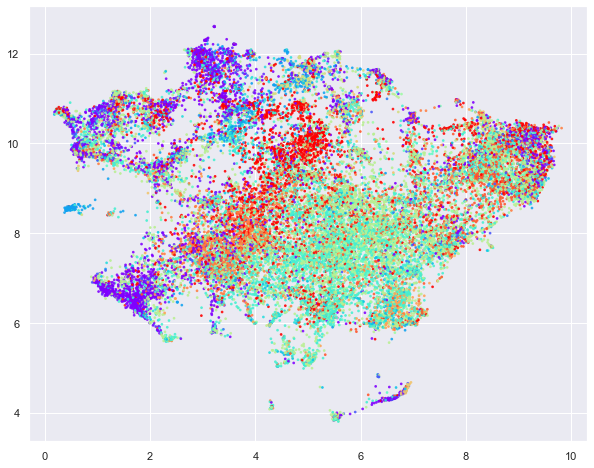

In [25]:
plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=movie_df_genre.Genre_Simple.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('SBERT_genre_PLT.png')

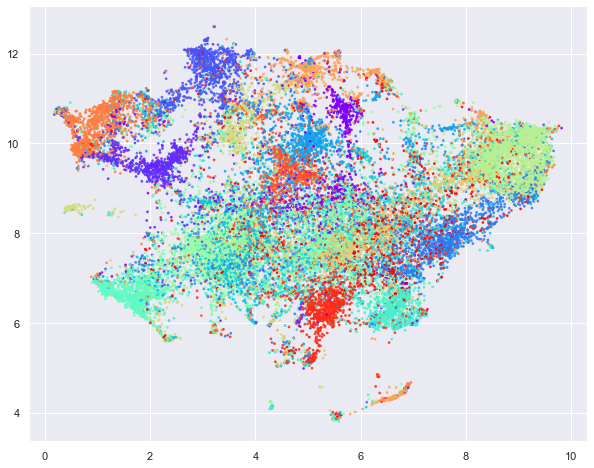

In [26]:
sc_df=pd.DataFrame(sc_clustering.labels_)
sc_df = sc_df.rename(columns = {0:'cluster'})


plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=sc_df.cluster.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('SBERT_cluster_PLT.png')

In [27]:
sbert_labels=sc_clustering.labels_

# 5. Compare to each other

In [30]:
normalized_mutual_info_score(sbert_labels, doc2vec_labels)

0.24894695822466964

In [31]:
normalized_mutual_info_score(sbert_labels, tfidf_labels)

0.2069039093724087

In [32]:
normalized_mutual_info_score(doc2vec_labels, tfidf_labels)

0.17149764829698785

# 6. Combining S-BERT and Doc2Vec

In [33]:
docsbert=pd.concat([decvec_genre, sbert_genre], axis=1)

In [34]:
W = pairwise_distances(docsbert, metric="euclidean") 
W.shape

(27667, 27667)

In [35]:
%%time
delta = 0.7
affinity = np.exp(- W ** 2 / (2. * delta ** 2))
sc = SpectralClustering(n_clusters=19, affinity='precomputed', random_state=0)
sc_clustering = sc.fit(affinity)

CPU times: user 3h 24min 9s, sys: 2min 59s, total: 3h 27min 8s
Wall time: 3h 32min 40s


In [36]:
normalized_mutual_info_score(sc_clustering.labels_, movie_df_genre['Genre_Simple'])

0.13512330407543197

In [37]:
%%time

reducer = umap.UMAP(random_state=42, n_components=2, min_dist=0)

scaled_document_embeddings2 = StandardScaler().fit_transform(docsbert)
scaled_document_embeddings2.shape


umapembeddings2 = reducer.fit_transform(scaled_document_embeddings2)
print(umapembeddings2.shape)
umapembeddings2=pd.DataFrame(umapembeddings2)

(27667, 2)
CPU times: user 35.1 s, sys: 1.96 s, total: 37.1 s
Wall time: 24.2 s


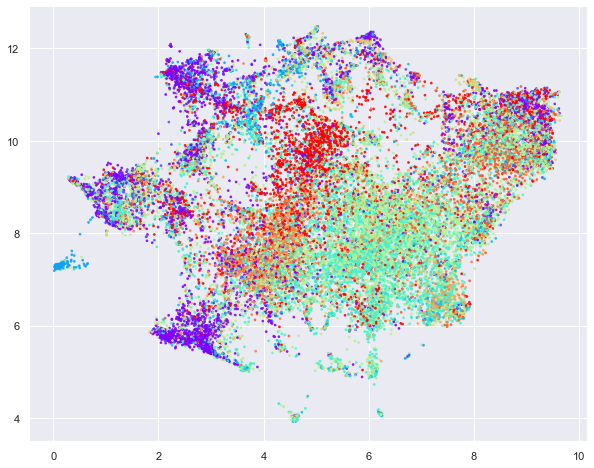

In [38]:
plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=movie_df_genre.Genre_Simple.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('DocVecSBERT_genre_PLT.png')

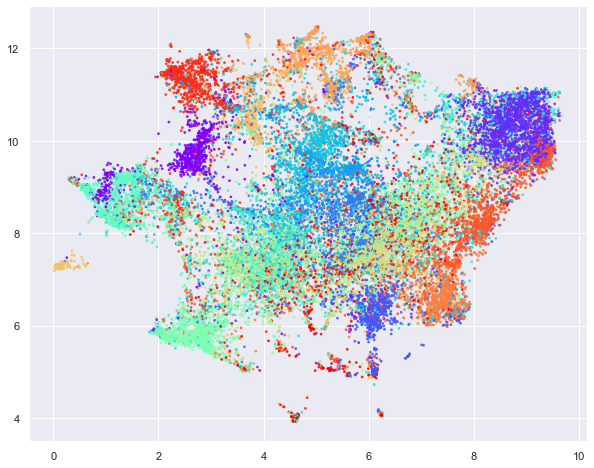

In [39]:
sc_df=pd.DataFrame(sc_clustering.labels_)
sc_df = sc_df.rename(columns = {0:'cluster'})


plt.figure(num=None, figsize=(10, 8))
plt.scatter(x=umapembeddings2[0],
            y=umapembeddings2[1],
            c=sc_df.cluster.astype('category').cat.codes, s=3, alpha=.8, cmap='rainbow')
plt.savefig('DocVecSBERT_cluster_PLT.png')

# 7. Case Studies

In [40]:
def closest_movies_tfidfumap(ind):
    target = tfidf.loc[movie_df['index']==ind]
    distances = distance.cdist(target, tfidf, "cosine")[0]
    closest = pd.DataFrame(distances)
    results = pd.merge(closest, movie_df, left_index=True, right_index=True)
    results = results.sort_values(0, ascending=True).head(11)
    return results[[0, 'Release Year', 'Title', 'Origin/Ethnicity', 'Genre']]

In [41]:
def closest_movies_d2v(ind):
    target = decvec.loc[movie_df['index']==ind]
    distances = distance.cdist(target, decvec, "cosine")[0]
    closest = pd.DataFrame(distances)
    results = pd.merge(closest, movie_df, left_index=True, right_index=True)
    results = results.sort_values(0, ascending=True).head(11)
    return results[[0, 'Release Year', 'Title', 'Origin/Ethnicity', 'Genre']]

In [42]:
def closest_movies_sbert(ind):
    target = sbert.loc[movie_df['index']==ind]
    distances = distance.cdist(target, sbert, "cosine")[0]
    closest = pd.DataFrame(distances)
    results = pd.merge(closest, movie_df, left_index=True, right_index=True)
    results = results.sort_values(0, ascending=True).head(11)
    return results[[0, 'Release Year', 'Title', 'Origin/Ethnicity', 'Genre']]

#### Casablanca

In [43]:
closest_movies_tfidfumap(24652)

,0,Release Year,Title,Origin/Ethnicity,Genre
24652,0.000000,1942,Casablanca,American,"drama, romance"
4663,0.745161,1945,Love Letters,American,drama
7126,0.783111,2015,Suite Française,British,unknown
28369,0.797698,1916,Sherlock Holmes,American,mystery
31074,0.803933,1939,Stronger Than Desire,American,drama
15700,0.805205,1939,Poison Pen,British,drama
4562,0.806050,1930,The W Plan,British,spy/world war i
20370,0.808738,1942,The Day Will Dawn,British,world war ii
24578,0.810580,1940,Neutral Port,British,war
4242,0.812786,1946,The Captive Heart,British,world war ii/drama


In [44]:
closest_movies_d2v(24652)

,0,Release Year,Title,Origin/Ethnicity,Genre
24652,0.000000,1942,Casablanca,American,"drama, romance"
19807,0.603836,1945,A Song to Remember,American,biography
5616,0.636898,1932,The Rich Are Always with Us,American,comedy
10135,0.651387,1934,The Iron Duke,British,historical
27293,0.667089,1958,Orders to Kill,British,world war ii
30210,0.669789,1944,Days of Glory,American,romantic drama
27404,0.672068,1942,This Was Paris,British,war
16429,0.673900,1955,The Right Person,British,drama
21266,0.675496,1965,Up from the Beach,American,war
29769,0.676327,1953,South Sea Woman,American,adventure


In [45]:
closest_movies_sbert(24652)

,0,Release Year,Title,Origin/Ethnicity,Genre
24652,0.000000,1942,Casablanca,American,"drama, romance"
23740,0.336285,1945,Cornered,American,film noir
32206,0.336980,2004,Before Sunset,American,drama
17200,0.338190,1951,An American in Paris,American,musical
27440,0.338771,1972,"Play It Again, Sam",American,comedy
10265,0.339982,2004,Head in the Clouds,British,romance/drama
17441,0.343875,1944,Hotel Reserve,British,espionage
27840,0.349672,1942,Secret Mission,British,world war ii
17503,0.356954,2011,Midnight in Paris,American,romantic comedy
26250,0.360305,1984,The Blood of Others,Canadian,drama


### Ferris Bueller's Day Off

In [46]:
closest_movies_tfidfumap(27650)

,0,Release Year,Title,Origin/Ethnicity,Genre
27650,0.000000,1986,Ferris Bueller's Day Off,American,comedy
10083,0.802419,2013,Another Me,British,unknown
8060,0.808252,1979,Over the Edge,American,drama
22943,0.809532,2007,Bridge to Terabithia,American,"family, fantasy"
31080,0.811079,1995,Welcome to the Dollhouse,American,drama
28752,0.812945,2007,Stuck,American,crime
8482,0.814473,1986,"Rita, Sue and Bob Too",British,drama
12557,0.817120,1987,"Planes, Trains and Automobiles",American,comedy
3015,0.817389,1998,Hope Floats,American,drama
19655,0.818992,2000,The Whole Nine Yards,American,"comedy, crime"


In [47]:
closest_movies_d2v(27650)

,0,Release Year,Title,Origin/Ethnicity,Genre
27650,0.000000,1986,Ferris Bueller's Day Off,American,comedy
11105,0.650197,2016,American Pastoral,American,unknown
19357,0.653167,2010,Dirty Girl,American,drama
3905,0.666480,2008,The Happening,American,horror
21320,0.681226,1998,Rushmore,American,comedy
32688,0.689945,2009,Amreeka,Canadian,immigrant family drama
9753,0.691469,2015,Focus,American,romantic comedy-drama
24347,0.692629,1987,Superstar: The Karen Carpenter Story,American,biography
7779,0.698771,2014,Mr. Peabody & Sherman,American,adventure
32876,0.698806,1938,Love Finds Andy Hardy,American,"comedy, romance"


In [48]:
closest_movies_sbert(27650)

,0,Release Year,Title,Origin/Ethnicity,Genre
27650,0.000000,1986,Ferris Bueller's Day Off,American,comedy
10873,0.270910,1987,Adventures in Babysitting,American,comedy
4182,0.293779,1988,License to Drive,American,comedy
7626,0.305376,1983,Risky Business,American,comedy
7754,0.306511,1975,"Aloha, Bobby and Rose",American,unknown
33206,0.314987,1992,Scent of a Woman,American,drama
2289,0.330421,2009,The Final Destination,American,horror
10306,0.330493,1989,Uncle Buck,American,"comedy, drama"
31028,0.333543,1967,Hot Rods to Hell,American,drama
13517,0.334015,1986,Dead-End Drive In,Australian,science fiction/action


### Sleepless in Seattle

In [49]:
closest_movies_tfidfumap(10431)

,0,Release Year,Title,Origin/Ethnicity,Genre
10431,0.000000,1993,Sleepless in Seattle,American,romantic comedy
10510,0.790748,1957,An Affair to Remember,American,romance
19926,0.806753,2012,Elevator,American,thriller
27352,0.813131,1994,Love Affair,American,romantic comedy
11655,0.816297,2013,Finding Mr. Right,Chinese,comedy / romance
16776,0.821752,2012,"London, Paris, New York",Bollywood,romance
16686,0.829035,2006,The Death of Poe,American,horror
29645,0.831154,1997,Elevated,American,short subject
31475,0.838540,2010,Chico and Rita,British,animation-drama
31533,0.839845,2005,The Weather Man,American,comedy-drama


In [50]:
closest_movies_d2v(10431)

,0,Release Year,Title,Origin/Ethnicity,Genre
10431,0.000000,1993,Sleepless in Seattle,American,romantic comedy
9500,0.610794,2001,Love on a Diet,Hong Kong,comedy / romance
1260,0.617554,2008,"Definitely, Maybe",American,romantic comedy
32206,0.622157,2004,Before Sunset,American,drama
11841,0.629472,2017,"Everything, Everything",American,"romance, drama"
14574,0.641158,1965,Where the Spies Are,British,spy thriller
14782,0.645214,1975,Night Moves,American,mystery
25726,0.647784,2013,Can a Song Save Your Life?,American,musical drama
2757,0.661287,2008,Dostana,Bollywood,comedy
10178,0.662592,2004,Yasmin,British,drama


In [51]:
closest_movies_sbert(10431)

,0,Release Year,Title,Origin/Ethnicity,Genre
10431,0.000000,1993,Sleepless in Seattle,American,romantic comedy
10510,0.266899,1957,An Affair to Remember,American,romance
24587,0.290548,2010,She's Out of My League,American,romantic comedy
14223,0.291787,1950,The Second Face,American,drama
26759,0.292173,1995,While You Were Sleeping,American,romantic comedy
17640,0.292582,2006,The Break-Up,American,romance
12366,0.293634,1964,Dear Heart,American,comedy
21876,0.294836,2002,Unfaithful,American,thriller
818,0.303795,1990,White Palace,American,drama
25505,0.303951,1934,Cross Country Cruise,American,romance


### Get Out

In [52]:
closest_movies_tfidfumap(25039)

,0,Release Year,Title,Origin/Ethnicity,Genre
25039,0.000000,2017,Get Out,American,horror
20279,0.743444,1959,Sapphire,British,drama
29251,0.797026,1997,Rosewood,American,drama
3099,0.800267,1976,Pressure,British,drama
28716,0.809969,1964,Nothing But a Man,American,drama
20954,0.813803,2004,Crash,American,crime drama
6853,0.815962,1964,Black Like Me,American,drama
4176,0.816005,1935,Murder in Harlem,American,"drama, mystery"
11980,0.816162,1995,Higher Learning,American,drama
23487,0.816596,1996,The Watermelon Woman,American,drama


In [53]:
closest_movies_d2v(25039)

,0,Release Year,Title,Origin/Ethnicity,Genre
25039,0.000000,2017,Get Out,American,horror
19829,0.632211,2012,House at the End of the Street,American,horror thriller
423,0.637409,2014,Get on Up,American,drama
23487,0.657880,1996,The Watermelon Woman,American,drama
18076,0.660847,2013,Contracted,American,horror
23144,0.663341,1979,Agatha,American,unknown
5559,0.667589,1965,I Saw What You Did,American,thriller
1448,0.670257,1957,Back from the Dead,American,horror
31007,0.675688,1951,Bahar,Bollywood,romantic drama
6662,0.682859,2010,Paranormal Activity 2,American,horror


In [54]:
closest_movies_sbert(25039)

,0,Release Year,Title,Origin/Ethnicity,Genre
25039,0.000000,2017,Get Out,American,horror
20438,0.225414,2006,Freedomland,American,crime drama
2681,0.230958,2008,Lakeview Terrace,American,thriller
7225,0.232080,2016,Kshanam,Telugu,thriller
8004,0.239566,1995,Devil in a Blue Dress,American,neo-noir
29577,0.243778,1950,No Way Out,American,film noir
14281,0.244381,1970,Watermelon Man,American,comedy
17935,0.250184,1965,Hysteria,British,thriller
31839,0.251299,1999,Stir of Echoes,American,horror
28673,0.260399,2002,Far from Heaven,American,drama
